In [21]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

from env import user, host, password
import explore

In [7]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def new_zillow_data():
    '''
    This function reads the zillow data from the Codeup db into a df,
    write it to a csv file, and returns the df.
    '''
    # Create SQL query.
    sql_query = ''' select * 
                    from properties_2017
                    join predictions_2017 using(parcelid)
                    where transactiondate between "2017-05-01" and "2017-06-30"
                    and unitcnt = 1;
                    '''
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_zillow_data(cached=False):
    '''
    This function reads in zillow data from Codeup database and writes data to
    a csv file if cached == False or if cached == True reads in telco df from
    a csv file, returns df.
    '''
    if cached == False or os.path.isfile('zillow.csv') == False:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow.csv')
        
    else:
        
        # If csv file exists or cached == True, read in data from csv.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    return df

In [42]:
zillow = get_zillow_data(cached=True)
zillow.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01
3,11967869,2093710,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,NaN,NaN,6.037185e+13,3429,-0.005566,2017-06-29
4,12035176,1288537,NaN,NaN,NaN,1.0,1.0,NaN,11.0,1.0,...,245906.0,2016.0,146810.0,2926.19,NaN,NaN,6.037189e+13,5444,-0.114435,2017-05-24


In [43]:
zillow = zillow.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "square_feet", "taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})

In [44]:
features = [
    "parcelid",
    "bedrooms",
    "bathrooms",
    "square_feet",
    "tax_value",
    'taxes',
    'yearbuilt',
    'regionidzip',
    'regionidneighborhood',
    'regionidcounty',
    'regionidcity',
    'fips'
]
zillow = zillow[features]
zillow = zillow.set_index('parcelid')



In [45]:
zillow.isna().sum()

bedrooms                   0
bathrooms                  0
square_feet                1
tax_value                  0
taxes                      1
yearbuilt                  6
regionidzip                3
regionidneighborhood    6431
regionidcounty             0
regionidcity             278
fips                       0
dtype: int64

In [46]:
zillow.shape

(13309, 11)

In [47]:
zillow.nunique()

bedrooms                   12
bathrooms                  12
square_feet              3079
tax_value               11074
taxes                   13212
yearbuilt                 124
regionidzip               277
regionidneighborhood      293
regionidcounty              2
regionidcity              123
fips                        2
dtype: int64

In [48]:
zillow = zillow.drop(columns=['regionidcounty','regionidneighborhood'])

In [49]:
zillow = zillow.dropna()
zillow.shape

(13024, 9)

In [50]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13024 entries, 11289917 to 12942897
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      13024 non-null  float64
 1   bathrooms     13024 non-null  float64
 2   square_feet   13024 non-null  float64
 3   tax_value     13024 non-null  float64
 4   taxes         13024 non-null  float64
 5   yearbuilt     13024 non-null  float64
 6   regionidzip   13024 non-null  float64
 7   regionidcity  13024 non-null  float64
 8   fips          13024 non-null  float64
dtypes: float64(9)
memory usage: 1017.5 KB


In [51]:
cat_vars = ['bedrooms','bathrooms','fips']
quant_vars = ['square_feet','tax_value','taxes','yearbuilt']

In [52]:
q1 = zillow.tax_value.quantile(.25)
q3 = zillow.tax_value.quantile(.75)
q1, q3

(187240.0, 545676.25)

In [53]:
iqr = q3 - q1
iqr

358436.25

In [54]:
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

In [55]:
zillow.shape

(13024, 9)

In [56]:
zillow = zillow[zillow.tax_value > lower_bound]
zillow.shape

(13024, 9)

In [57]:
zillow = zillow[zillow.tax_value < upper_bound]
zillow.shape

(12063, 9)

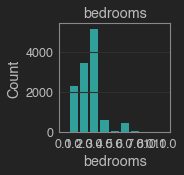

      bedrooms  Count  Percent
3.0        3.0   5146    42.66
2.0        2.0   3428    28.42
4.0        1.0   2306    19.12
1.0        4.0    586     4.86
5.0        6.0    456     3.78
6.0        5.0     66     0.55
0.0        7.0     64     0.53
7.0        0.0      8     0.07
11.0      11.0      1     0.01
10.0       8.0      1     0.01
8.0       10.0      1     0.01
_________________________________________________________________


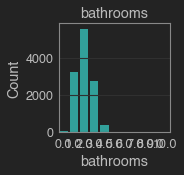

      bathrooms  Count  Percent
2.0         2.0   5585    46.30
3.0         1.0   3249    26.93
1.0         3.0   2741    22.72
4.0         4.0    380     3.15
5.0         0.0     82     0.68
6.0         6.0     12     0.10
0.0         5.0      9     0.07
7.0         7.0      2     0.02
9.0         9.0      1     0.01
10.0        8.0      1     0.01
8.0        10.0      1     0.01
_________________________________________________________________


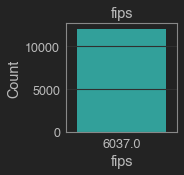

          fips  Count  Percent
6037.0  6037.0  12063    100.0
_________________________________________________________________


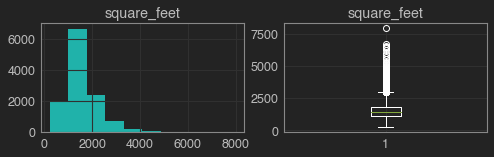

count    12063.00000
mean      1574.66219
std        668.57175
min        242.00000
25%       1122.00000
50%       1430.00000
75%       1855.00000
max       7942.00000
Name: square_feet, dtype: float64


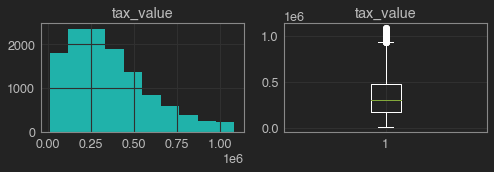

count    1.206300e+04
mean     3.545132e+05
std      2.325971e+05
min      1.050400e+04
25%      1.760410e+05
50%      3.096510e+05
75%      4.810000e+05
max      1.082259e+06
Name: tax_value, dtype: float64


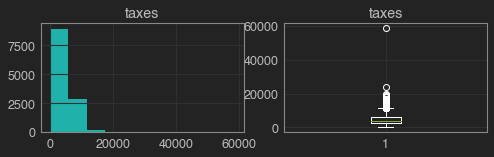

count    12063.000000
mean      4565.521242
std       2824.933792
min        120.840000
25%       2474.030000
50%       4066.600000
75%       6054.360000
max      58634.770000
Name: taxes, dtype: float64


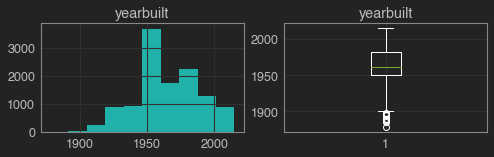

count    12063.000000
mean      1964.317334
std         23.614110
min       1878.000000
25%       1950.000000
50%       1962.000000
75%       1983.000000
max       2015.000000
Name: yearbuilt, dtype: float64


In [58]:

explore.explore_univariate(zillow,cat_vars,quant_vars)

In [30]:
def split_zillow(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name
    """
    
    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(df, test_size=.3, random_state=123)
    else:
        train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate[stratify_by])
    
    return train, validate, test

In [59]:
train, validate, test = split_zillow(zillow)

bedrooms 
_____________________

           chi2       p-value  degrees of freedom
0  59679.077119  3.201886e-07               57968

observed:
 tax_value  10504.0  11089.0  11683.0  14284.0  16084.0  16514.0  16722.0  \
bedrooms                                                                   
0.0              0        1        0        0        0        0        0   
1.0              0        0        1        0        0        1        0   
2.0              1        0        0        0        1        0        0   
3.0              0        0        0        1        0        0        1   
4.0              0        0        0        0        0        0        0   
5.0              0        0        0        0        0        0        0   
6.0              0        0        0        0        0        0        0   
7.0              0        0        0        0        0        0        0   
11.0             0        0        0        0        0        0        0   
All              1 

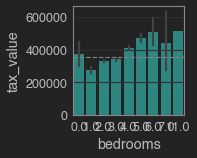


_____________________

bathrooms 
_____________________

           chi2       p-value  degrees of freedom
0  70921.938346  1.343860e-53               65214

observed:
 tax_value  10504.0  11089.0  11683.0  14284.0  16084.0  16514.0  16722.0  \
bathrooms                                                                  
0.0              0        1        0        0        0        0        0   
1.0              1        0        1        1        1        1        1   
2.0              0        0        0        0        0        0        0   
3.0              0        0        0        0        0        0        0   
4.0              0        0        0        0        0        0        0   
5.0              0        0        0        0        0        0        0   
6.0              0        0        0        0        0        0        0   
7.0              0        0        0        0        0        0        0   
8.0              0        0        0        0        0        0       

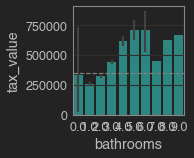


_____________________

fips 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 tax_value  10504.0  11089.0  11683.0  14284.0  16084.0  16514.0  16722.0  \
fips                                                                       
6037.0           1        1        1        1        1        1        1   
All              1        1        1        1        1        1        1   

tax_value  16723.0  18589.0  19476.0  ...  1077046.0  1079025.0  1079282.0  \
fips                                  ...                                    
6037.0           1        1        1  ...          1          1          1   
All              1        1        1  ...          1          1          1   

tax_value  1079501.0  1079800.0  1079954.0  1080000.0  1081843.0  1082259.0  \
fips                                                                          
6037.0             1          1          1          1          1          1   
All   

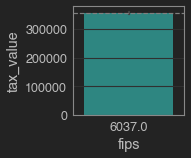


_____________________

square_feet 
____________________



KeyboardInterrupt: 

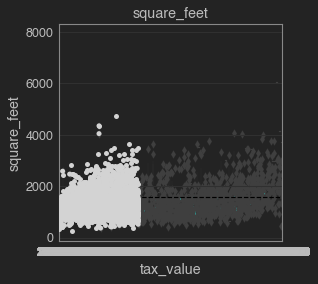

In [60]:
plt.rcParams['figure.figsize'] = (4, 2)
explore.explore_bivariate(train,'tax_value',cat_vars,quant_vars)

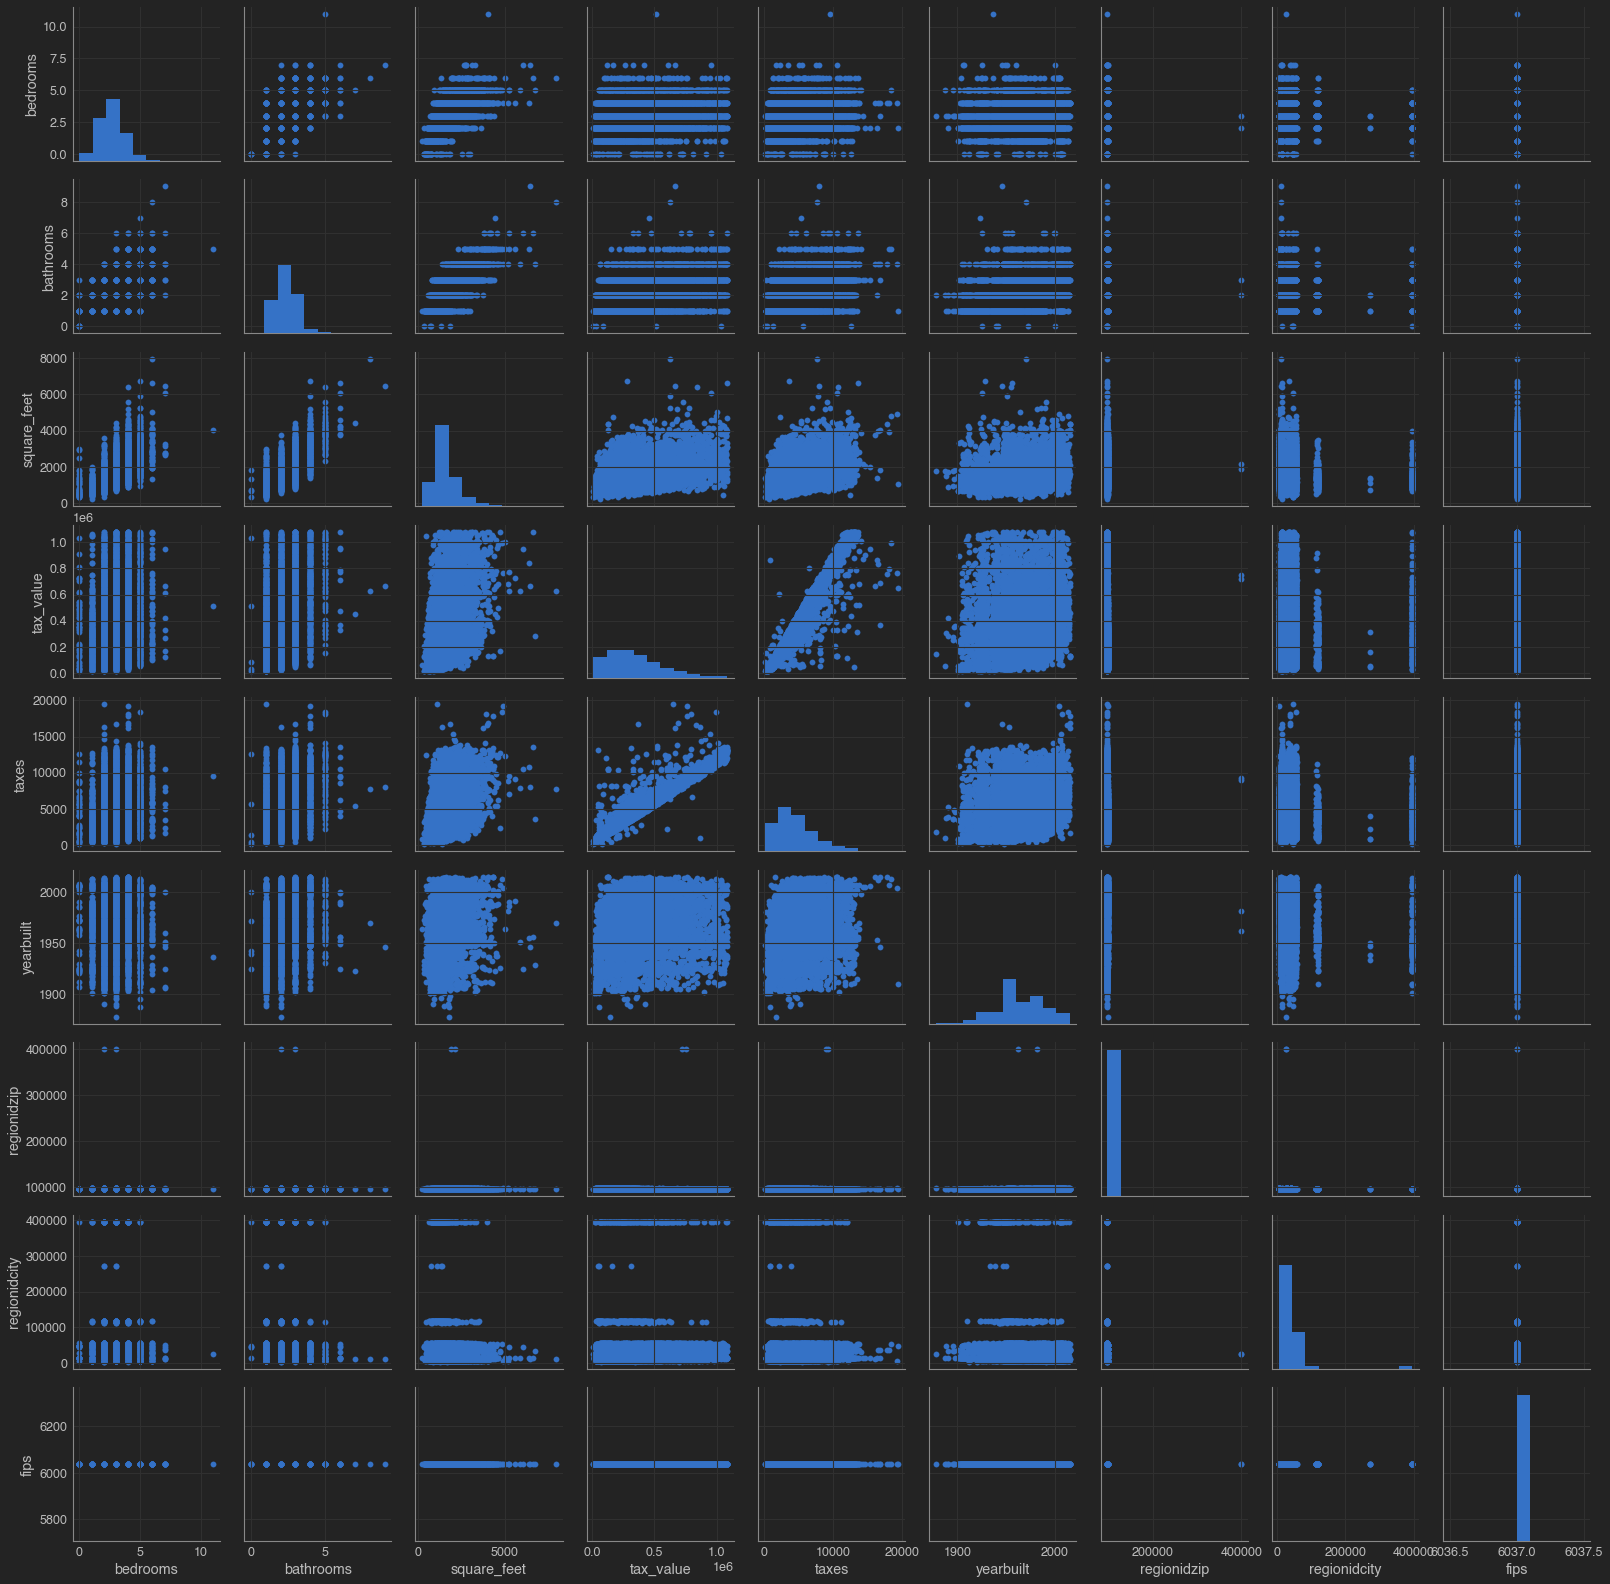

In [61]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

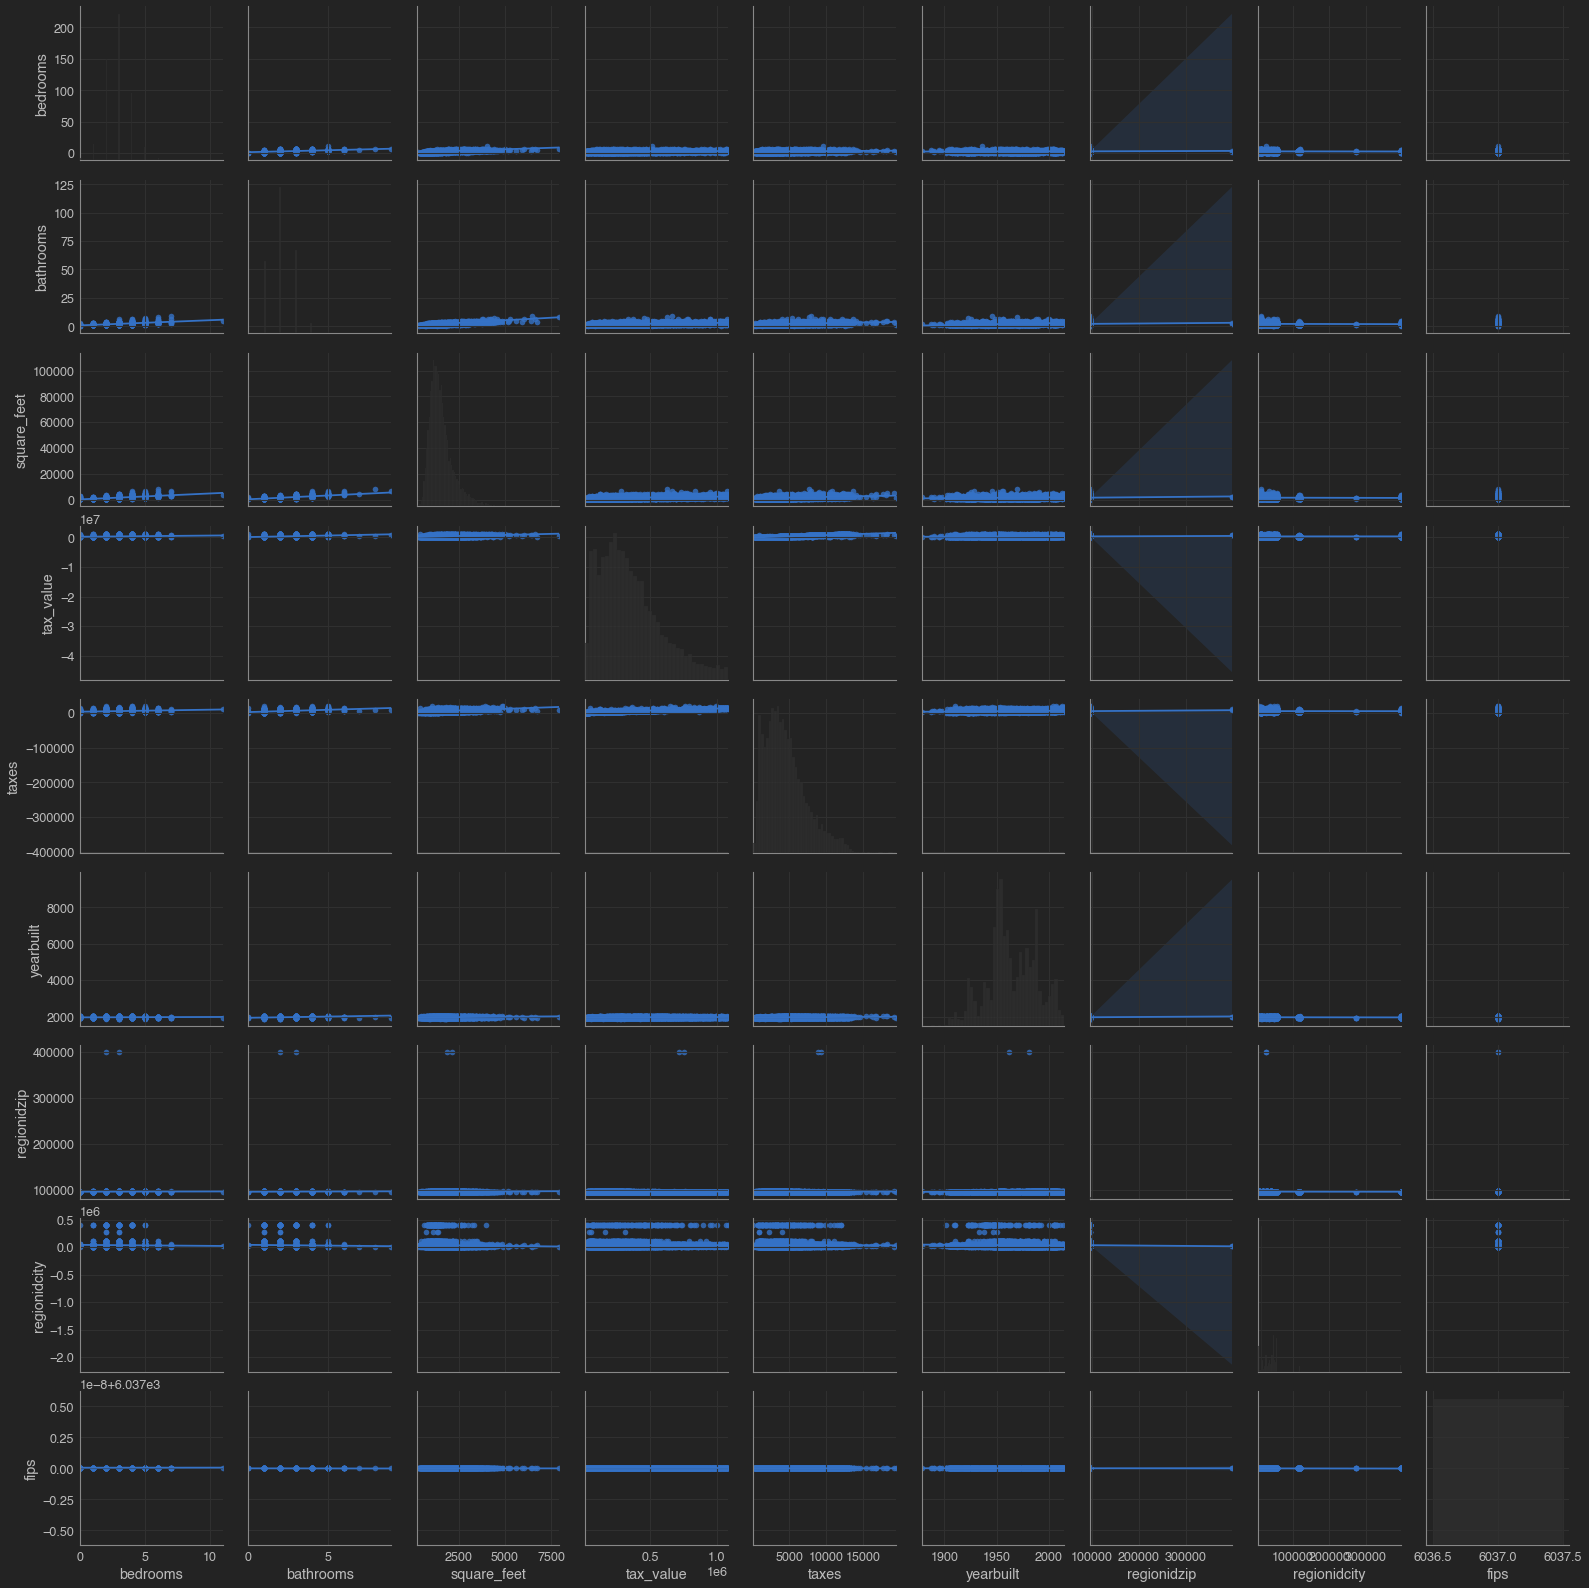

In [63]:
sns.pairplot(train, kind='reg')

### 1. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.


### 3. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

### 4. Save the functions you have written to create visualizations in a file named explore.py. Rewrite your notebook code so that you are using the functions imported from this file.

### 5. Explore your dataset with any other visualizations you think will be helpful.

### 6In a seperate notebook, use the functions you have developed in this exercise with the mall customers dataset.